In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Updated for scikit-learn 1.2+ (plot_roc_curve is deprecated)
from sklearn.metrics import RocCurveDisplay



In [2]:
df = pd.read_csv('heart-disease.csv')  # Note: filename has hyphen, not underscore
df.shape

(303, 14)

In [3]:
df["target"].value_counts()
df["target"].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);


In [4]:
df["sex"].value_counts()

sex
1    207
0     96
Name: count, dtype: int64

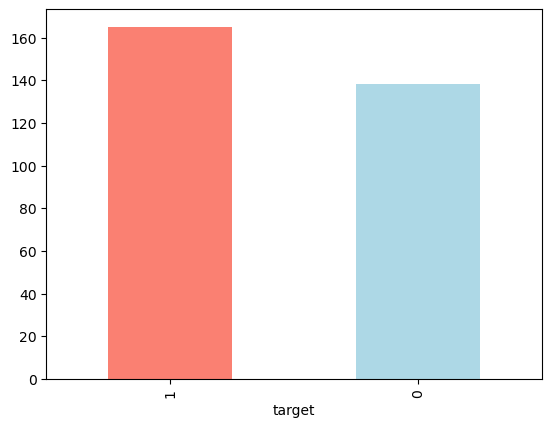

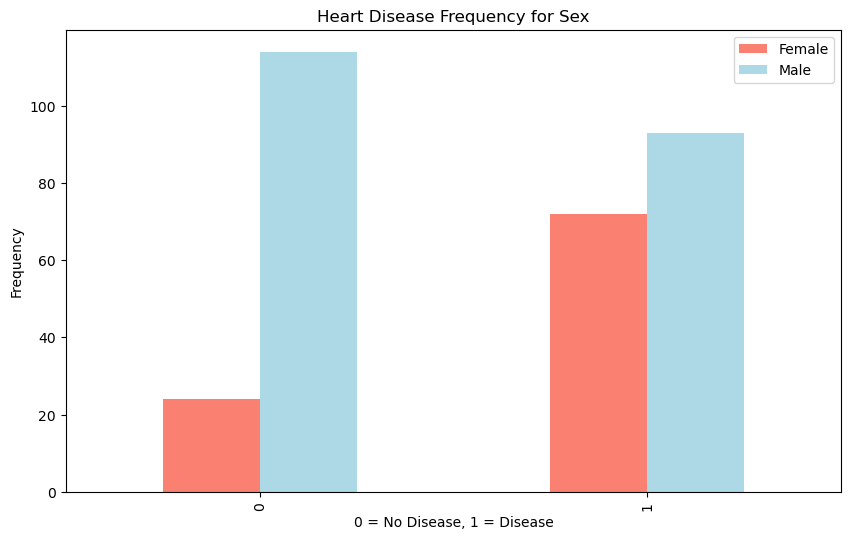

In [5]:
pd.crosstab(df.target, df.sex)
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10, 6),
                                    color=['salmon', 'lightblue'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male']);
plt.show()

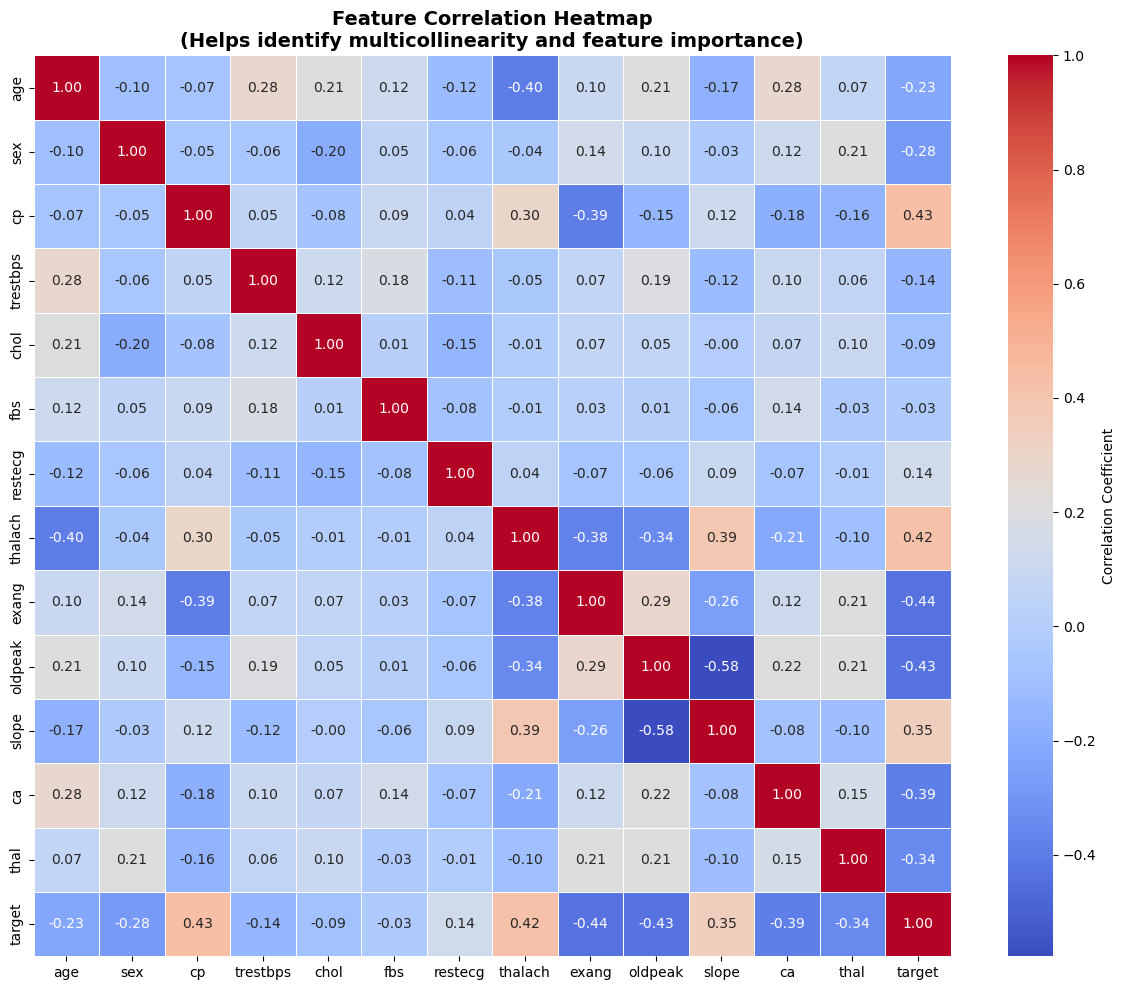

In [6]:
# Correlation Heatmap - Shows relationships between all features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap\n(Helps identify multicollinearity and feature importance)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


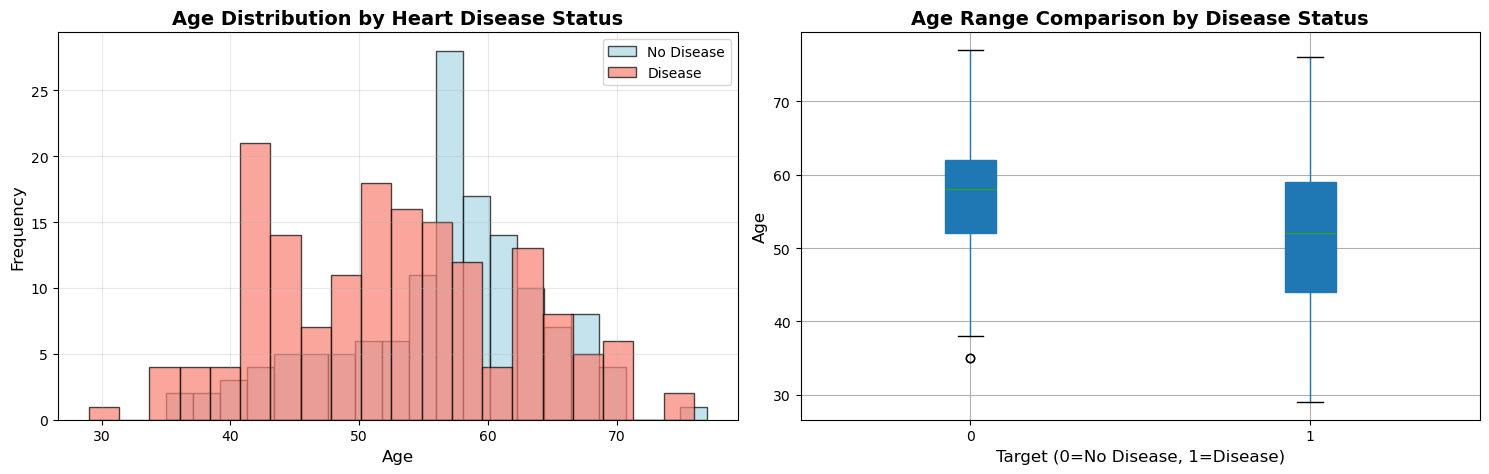


Age Statistics by Target:
        count       mean       std   min   25%   50%   75%   max
target                                                          
0       138.0  56.601449  7.962082  35.0  52.0  58.0  62.0  77.0
1       165.0  52.496970  9.550651  29.0  44.0  52.0  59.0  76.0


In [7]:
# Age Distribution Analysis - Compare age patterns between healthy and disease groups
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df[df['target'] == 0]['age'], bins=20, alpha=0.7, label='No Disease', color='lightblue', edgecolor='black')
axes[0].hist(df[df['target'] == 1]['age'], bins=20, alpha=0.7, label='Disease', color='salmon', edgecolor='black')
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Age Distribution by Heart Disease Status', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
df.boxplot(column='age', by='target', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Target (0=No Disease, 1=Disease)', fontsize=12)
axes[1].set_ylabel('Age', fontsize=12)
axes[1].set_title('Age Range Comparison by Disease Status', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Summary statistics
print("\nAge Statistics by Target:")
print(df.groupby('target')['age'].describe())


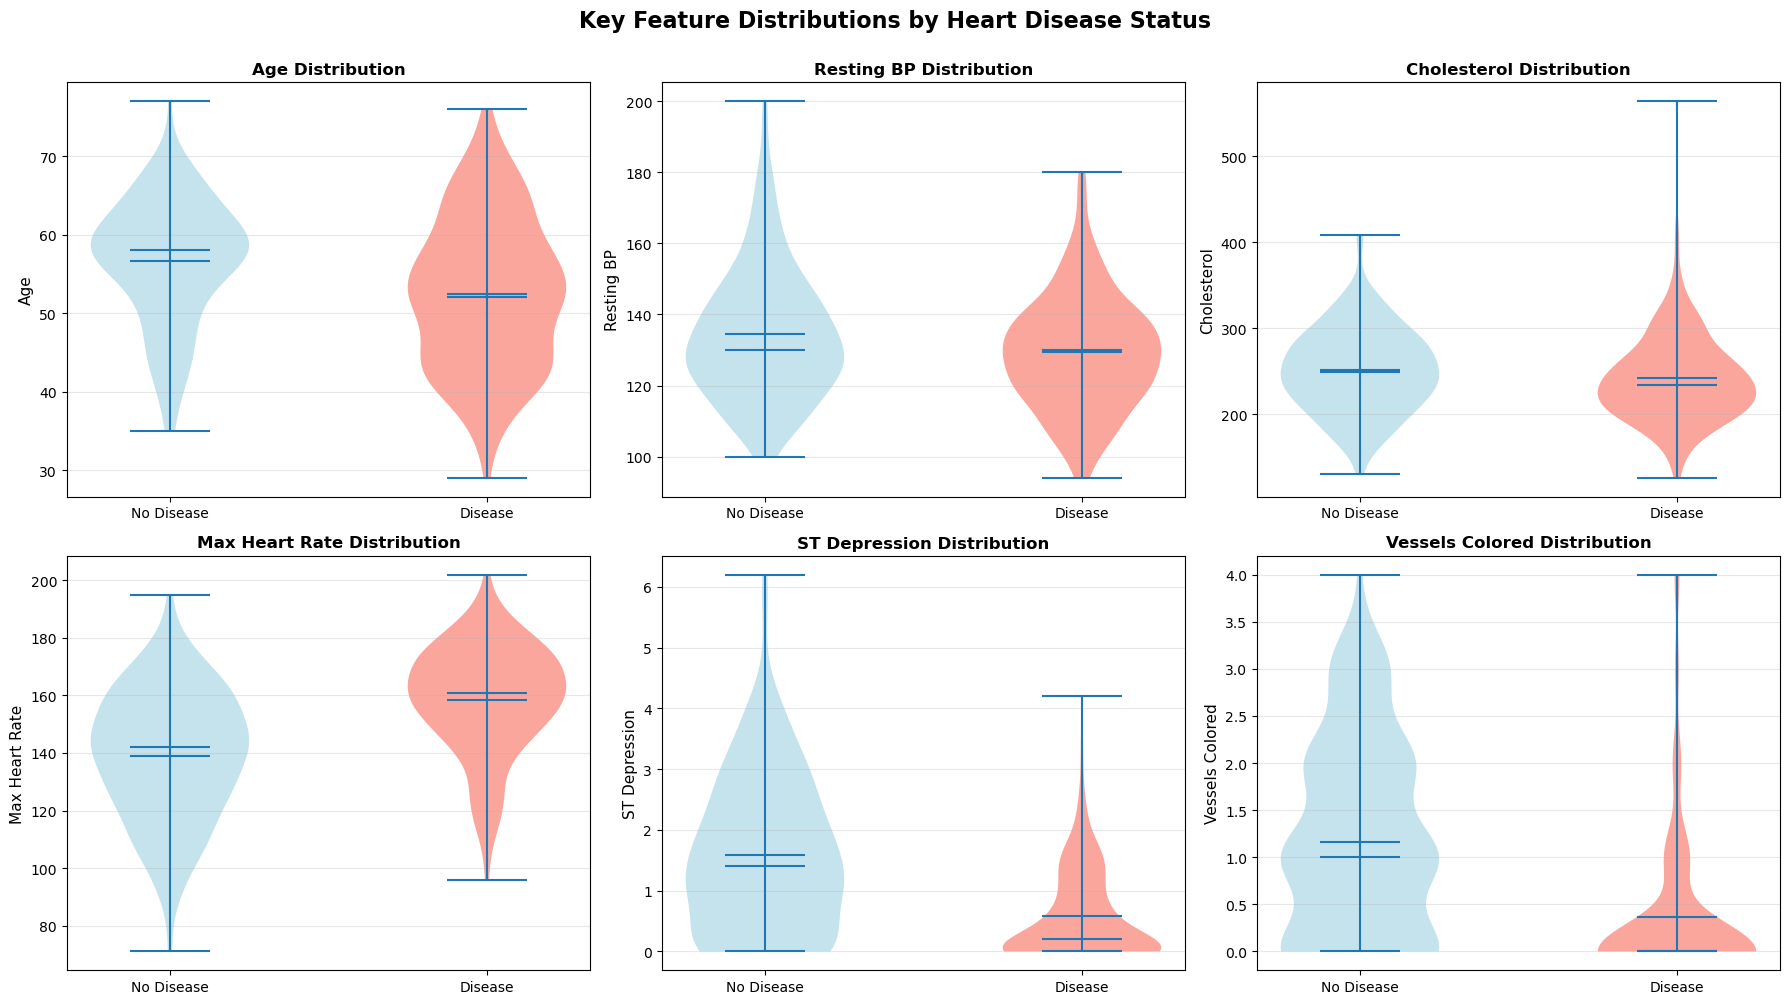

In [8]:
# Multiple Feature Distributions - Comprehensive view of key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Feature Distributions by Heart Disease Status', fontsize=16, fontweight='bold', y=1.00)

# Features to plot
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
feature_names = ['Age', 'Resting BP', 'Cholesterol', 'Max Heart Rate', 'ST Depression', 'Vessels Colored']

for idx, (feature, name) in enumerate(zip(features, feature_names)):
    row = idx // 3
    col = idx % 3
    
    # Violin plot for better distribution visualization
    parts = axes[row, col].violinplot(
        [df[df['target'] == 0][feature].dropna(), 
         df[df['target'] == 1][feature].dropna()],
        positions=[0, 1],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    colors = ['lightblue', 'salmon']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_xticklabels(['No Disease', 'Disease'])
    axes[row, col].set_ylabel(name, fontsize=11)
    axes[row, col].set_title(f'{name} Distribution', fontsize=12, fontweight='bold')
    axes[row, col].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


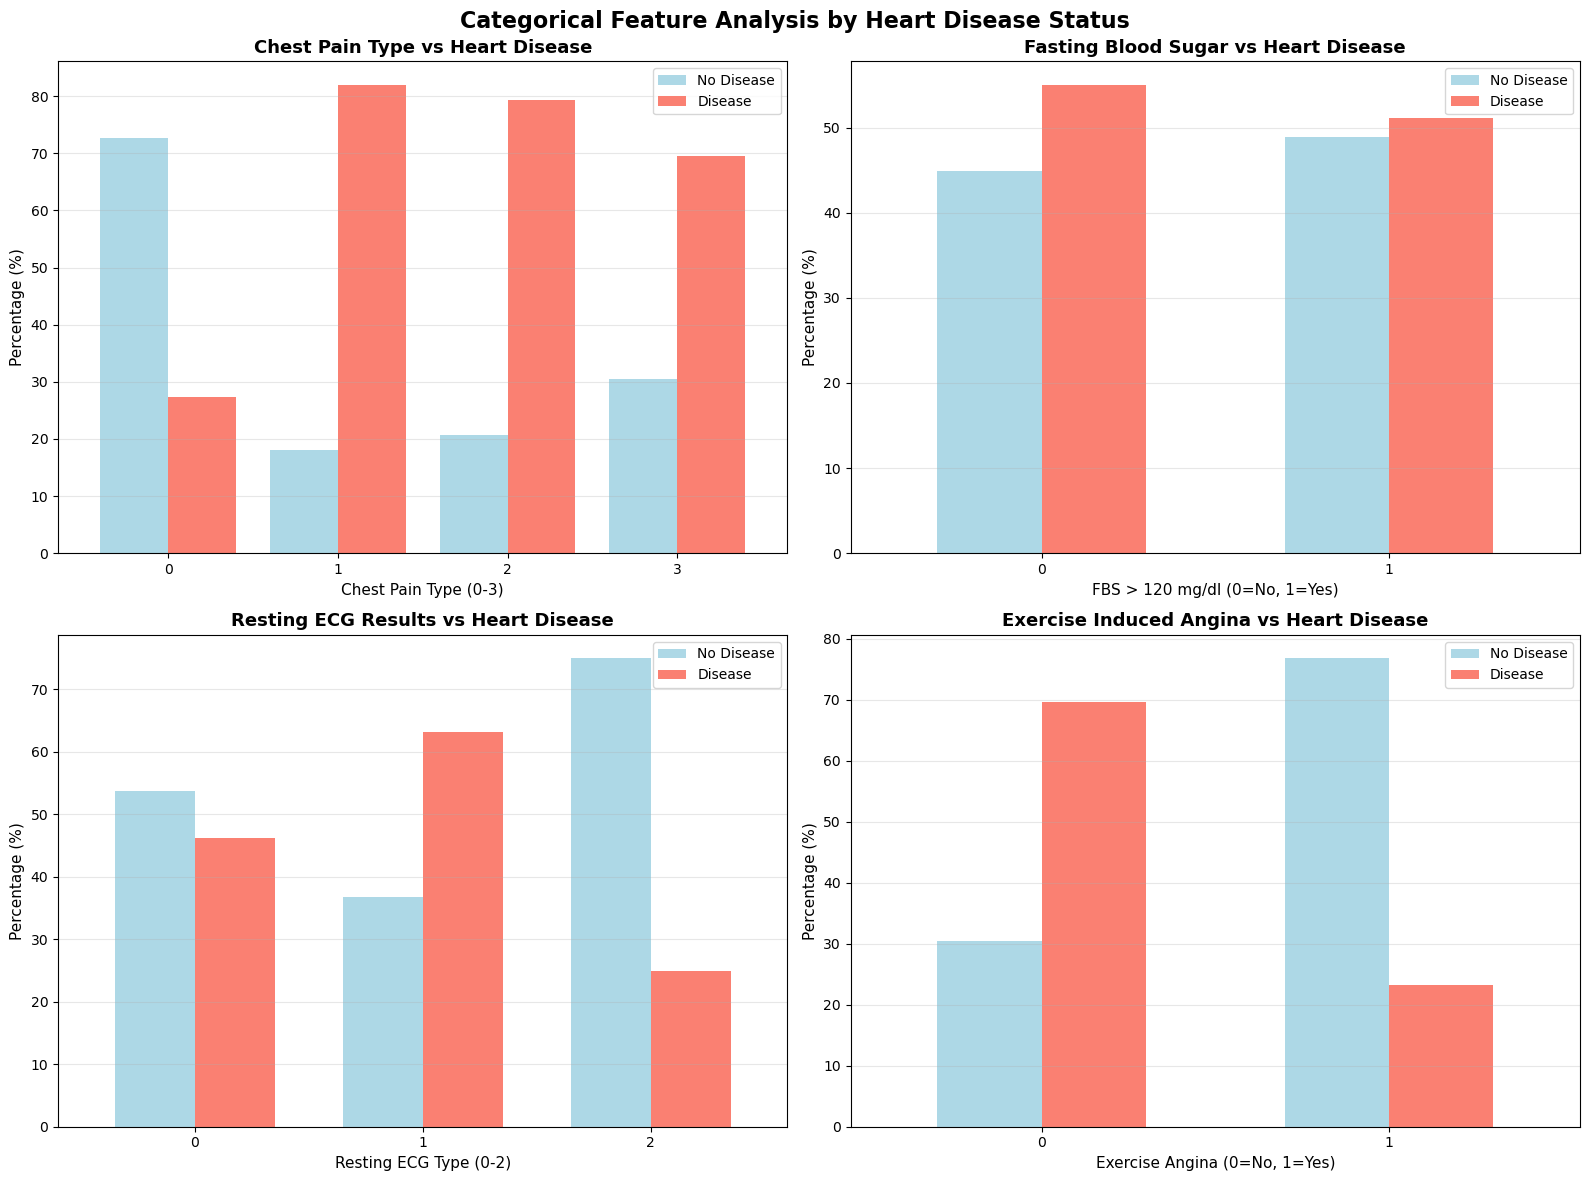


=== Categorical Feature Summary ===

Chest Pain Types Distribution:
cp
0    143
1     50
2     87
3     23
Name: count, dtype: int64

Exercise Induced Angina:
exang
0    204
1     99
Name: count, dtype: int64


In [9]:
# Categorical Features Analysis - Understanding patterns in categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Categorical Feature Analysis by Heart Disease Status', fontsize=16, fontweight='bold')

# 1. Chest Pain Type (cp)
cp_crosstab = pd.crosstab(df['cp'], df['target'], normalize='index') * 100
cp_crosstab.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'salmon'], width=0.8)
axes[0, 0].set_title('Chest Pain Type vs Heart Disease', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Chest Pain Type (0-3)', fontsize=11)
axes[0, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 0].legend(['No Disease', 'Disease'], loc='upper right')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Fasting Blood Sugar (fbs)
fbs_crosstab = pd.crosstab(df['fbs'], df['target'], normalize='index') * 100
fbs_crosstab.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'salmon'], width=0.6)
axes[0, 1].set_title('Fasting Blood Sugar vs Heart Disease', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('FBS > 120 mg/dl (0=No, 1=Yes)', fontsize=11)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 1].legend(['No Disease', 'Disease'], loc='upper right')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Resting ECG (restecg)
restecg_crosstab = pd.crosstab(df['restecg'], df['target'], normalize='index') * 100
restecg_crosstab.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'salmon'], width=0.7)
axes[1, 0].set_title('Resting ECG Results vs Heart Disease', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Resting ECG Type (0-2)', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].legend(['No Disease', 'Disease'], loc='upper right')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Exercise Induced Angina (exang)
exang_crosstab = pd.crosstab(df['exang'], df['target'], normalize='index') * 100
exang_crosstab.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'salmon'], width=0.6)
axes[1, 1].set_title('Exercise Induced Angina vs Heart Disease', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Exercise Angina (0=No, 1=Yes)', fontsize=11)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 1].legend(['No Disease', 'Disease'], loc='upper right')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Categorical Feature Summary ===")
print(f"\nChest Pain Types Distribution:\n{df['cp'].value_counts().sort_index()}")
print(f"\nExercise Induced Angina:\n{df['exang'].value_counts()}")


In [10]:
# Prepare data for modeling
# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFirst few rows of features:\n{X.head()}")


Features shape: (303, 13)
Target shape: (303,)

First few rows of features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  
0   0     1  
1   0     2  
2   0     2  
3   0     2  
4   0     2  


In [11]:
# Split data into training and testing sets
# Using 80-20 split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())


Training set size: 242 samples
Testing set size: 61 samples
Feature count: 13

Class distribution in training set:
target
1    133
0    109
Name: count, dtype: int64


In [12]:
# Train a Random Forest Classifier
# Initialize and train the model
np.random.seed(42)
rf_model = RandomForestClassifier(n_estimators=100, 
                                 random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Calculate and display accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


Model Performance Metrics:
Accuracy:  0.836
Precision: 0.844
Recall:    0.844
F1 Score:  0.844


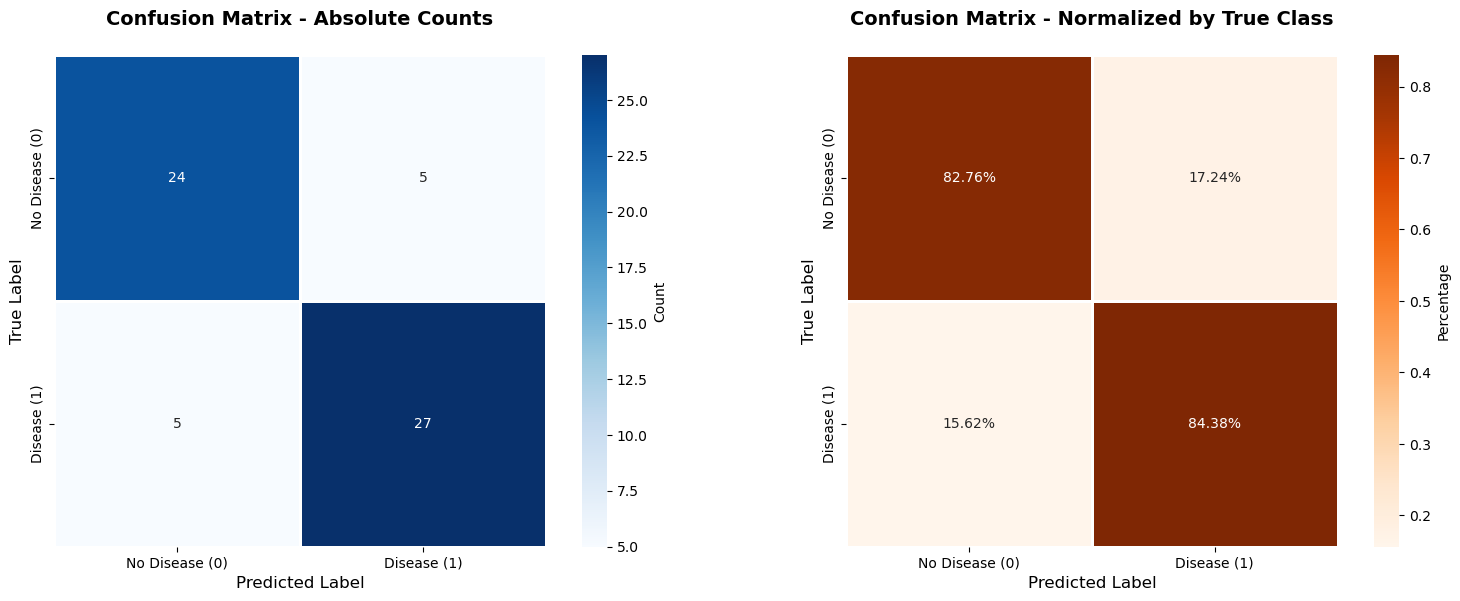


Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.83      0.83      0.83        29
     Disease       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


Confusion Matrix Breakdown:
  True Negatives (TN):  24 - Correctly predicted No Disease
  False Positives (FP): 5 - Incorrectly predicted Disease
  False Negatives (FN): 5 - Incorrectly predicted No Disease
  True Positives (TP):  27 - Correctly predicted Disease


In [13]:
# Confusion Matrix Heatmap - Visualize model predictions
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a more detailed visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='white',
            ax=axes[0],
            square=True,
            cbar=True)
axes[0].set_title('Confusion Matrix - Absolute Counts\n', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'])
axes[0].set_yticklabels(['No Disease (0)', 'Disease (1)'])

# Plot 2: Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'},
            linewidths=2, linecolor='white',
            ax=axes[1],
            square=True,
            cbar=True)
axes[1].set_title('Confusion Matrix - Normalized by True Class\n', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['No Disease (0)', 'Disease (1)'])
axes[1].set_yticklabels(['No Disease (0)', 'Disease (1)'])

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, 
                          target_names=['No Disease', 'Disease']))
print("=" * 60)

# Interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn} - Correctly predicted No Disease")
print(f"  False Positives (FP): {fp} - Incorrectly predicted Disease")
print(f"  False Negatives (FN): {fn} - Incorrectly predicted No Disease")
print(f"  True Positives (TP):  {tp} - Correctly predicted Disease")


In [14]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [15]:
x = df.drop('target', axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [16]:
from sklearn.ensemble import RandomForestClassifier

classifier_model = RandomForestClassifier()
classifier_model.fit(x_train, y_train)

classifier_model.score(x_test, y_test)


0.8360655737704918

In [17]:
from sklearn.ensemble import RandomForestRegressor

regressor_model = RandomForestRegressor()
regressor_model.fit(x_train, y_train)

regressor_model.score(x_test, y_test)


0.5253306034482759

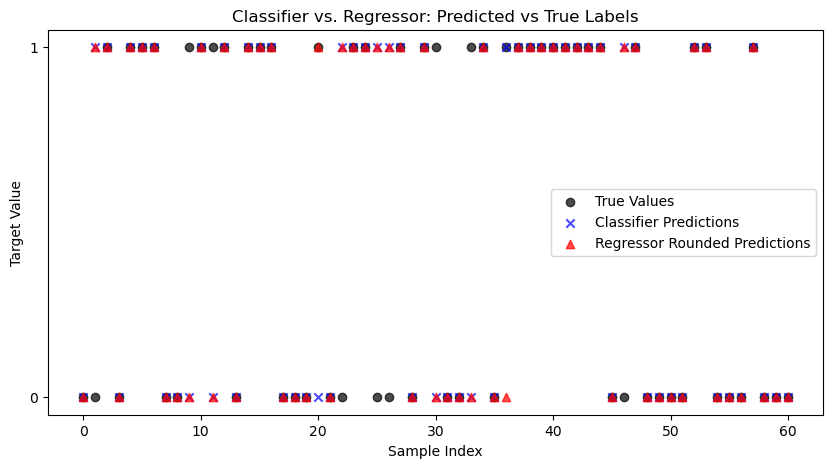

Classifier (RandomForestClassifier) Accuracy: 0.8360655737704918
Regressor (RandomForestRegressor, rounded) Accuracy: 0.8360655737704918


In [18]:
#plotting regressor model vs classifier model
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from both models
y_pred_class = classifier_model.predict(x_test)
y_pred_reg = regressor_model.predict(x_test)

# If regressor output is not binary, round to 0 or 1
y_pred_reg_rounded = np.round(y_pred_reg)

# Scatter plot: True labels vs. predictions
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), y_test, color='black', label="True Values", marker='o', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_class, color='blue', label="Classifier Predictions", marker='x', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_reg_rounded, color='red', label="Regressor Rounded Predictions", marker='^', alpha=0.7)
plt.title("Classifier vs. Regressor: Predicted vs True Labels")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.yticks([0,1])
plt.legend()
plt.show()

# Optional: Compare accuracy of both approaches on classification task
from sklearn.metrics import accuracy_score

acc_classifier = accuracy_score(y_test, y_pred_class)
acc_regressor = accuracy_score(y_test, y_pred_reg_rounded)

print("Classifier (RandomForestClassifier) Accuracy:", acc_classifier)
print("Regressor (RandomForestRegressor, rounded) Accuracy:", acc_regressor)


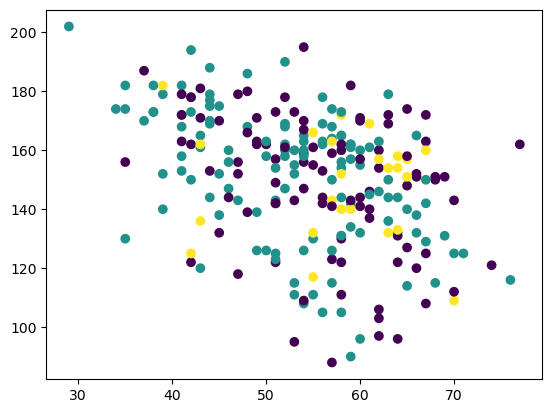

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(x_train)

plt.scatter(x_train['age'], x_train['thalach'], c=kmeans.labels_)
plt.show()


In [20]:
def compare_models(models, x_train, y_train):
    for model in models:
        model.fit(x_train, y_train)
        print(model.score(x_test, y_test))

compare_models([classifier_model, regressor_model, kmeans], x_train, y_train)

0.8360655737704918
0.5278350215517242
-102747.73200837422


<Figure size 1000x500 with 0 Axes>

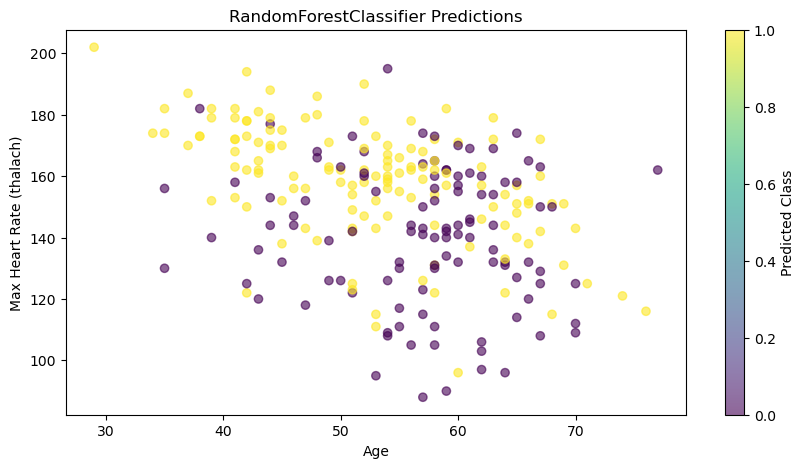

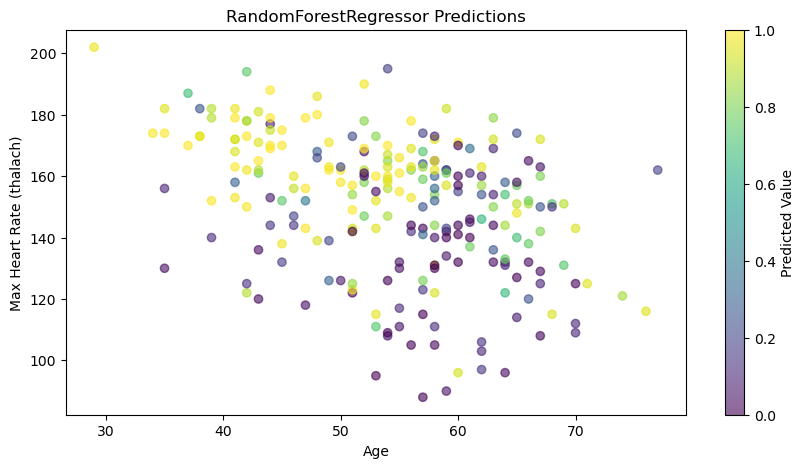

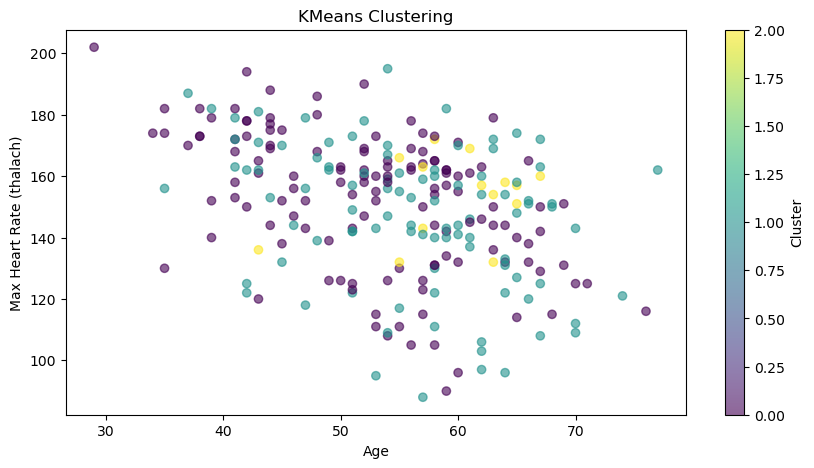

In [22]:
def plot_model_comparison(models, x_train, y_train):
    for model in models:
        model.fit(x_train, y_train)
        plt.figure(figsize=(10, 5))
        
        # Check if it's a clustering model (has labels_)
        if hasattr(model, 'labels_'):
            # For clustering models (like KMeans)
            colors = model.labels_
            title = f'{model.__class__.__name__} Clustering'
            colorbar_label = 'Cluster'
        else:
            # For classifiers and regressors (use predictions)
            colors = model.predict(x_train)
            if model.__class__.__name__ in ['RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier']:
                title = f'{model.__class__.__name__} Predictions'
                colorbar_label = 'Predicted Class'
            else:
                title = f'{model.__class__.__name__} Predictions'
                colorbar_label = 'Predicted Value'
        
        plt.scatter(x_train['age'], x_train['thalach'], c=colors, cmap='viridis', alpha=0.6)
        plt.colorbar(label=colorbar_label)
        plt.xlabel('Age')
        plt.ylabel('Max Heart Rate (thalach)')
        plt.title(title)
        plt.show()

plot_model_comparison([classifier_model, regressor_model, kmeans], x_train, y_train)

In [ ]:
def print_tuned_parameters(model):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        model.fit(x_train, y_train)
        print(f"n_estimators: {param}, score: {model.score(x_test, y_test)}")

print_tuned_parameters(classifier_model)


n_estimators: 10, score: 0.8032786885245902
n_estimators: 20, score: 0.8524590163934426
n_estimators: 30, score: 0.8524590163934426
n_estimators: 40, score: 0.8360655737704918
n_estimators: 50, score: 0.8524590163934426
n_estimators: 60, score: 0.8524590163934426
n_estimators: 70, score: 0.8524590163934426
n_estimators: 80, score: 0.8688524590163934
n_estimators: 90, score: 0.8524590163934426
n_estimators: 100, score: 0.8524590163934426


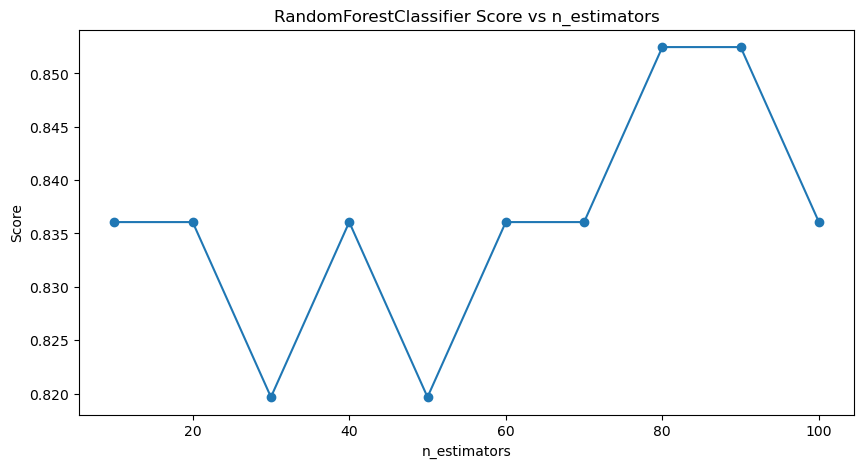

In [26]:
def plot_model_comparison_hyperparameters(model, x_train, y_train):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    scores = []
    
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))
    
    plt.figure(figsize=(10, 5))
    plt.plot(hyperparameters, scores, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('Score')
    plt.title(f'{model.__class__.__name__} Score vs n_estimators')
    plt.show()
   
plot_model_comparison_hyperparameters(classifier_model, x_train, y_train)

In [31]:
from sklearn.model_selection import cross_val_score

def cross_val_score_per_hyperparameter(model, x_train, y_train):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    scores = []
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        scores.append(cross_val_score(model, x_train, y_train, cv=5).mean())
    return scores
cross_val_score_per_hyperparameter(classifier_model, x_train, y_train)

[np.float64(0.8181972789115648),
 np.float64(0.7975340136054422),
 np.float64(0.8140306122448979),
 np.float64(0.7852040816326531),
 np.float64(0.8181122448979592),
 np.float64(0.8099489795918366),
 np.float64(0.8141156462585034),
 np.float64(0.8098639455782312),
 np.float64(0.8097789115646258),
 np.float64(0.8140306122448979)]